# Classification of Twitter Username by Tweets

<b> Author: </b> Shannon Snively

This notebook will show the accuracy of classifying username based on a btach of their most recent tweets. To get the data I used the Twitter API, Tweepy, and collected 3200 tweets for a given username input.

<b> Required packages: </b>
* Tweepy Authentication Tokens
* Tweepy 
* bs4
* wordcloud
* sklearn

In [1]:
import warnings
warnings.filterwarnings('ignore')
# import string

# Introduction

How well do we know a person by the way that they talk? An even better question is how well do we know a person when they post to social media?

This notebook attempts to answer the question, whether it is possible to detect the difference of a person from the text content in their most recent tweets.

# Collecting Data

The authorization tokens from the Tweepy API, were uploaded into a .json file in order for them to remain secure. 

Using the Tweepy API, I created a function that pulled the max amount of tweets allowed per user (3200) through the user_timeline function. The tweets were placed into a list, and returned as a dataframe with the user's Id, date/time tweet was created, and content of the tweet.

In [2]:
import pandas as pd
import numpy as np
import requests, io, json, re, tweepy
from tweepy import OAuthHandler #Stream, StreamListener
from bs4 import BeautifulSoup

In [3]:
creds = json.load(io.open(r'C:\Users\Shannon\Documents\GitHub\Twitter\config_secret.json'))

auth = OAuthHandler(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET'])
auth.set_access_token(creds['OAUTH_TOKEN'], creds['OAUTH_TOKEN_SECRET'])

api = tweepy.API(auth)

In [4]:
def get_tweets(screen_name):
    """ 
    returns a dataframe of twitter users name, date/time tweet was created
    and the text content from the tweet.
    """
    
    tweets = []
    
    user_tweets = api.user_timeline(screen_name = screen_name, count = 200)
    tweets.extend(user_tweets)
    
    last_tweet = tweets[-1].id - 1
    
    while len(user_tweets) > 0:
        #print('getting tweets before %s' %(last_tweet))
        
        user_tweets = api.user_timeline(screen_name=screen_name, count=200, max_id=last_tweet)
        tweets.extend(user_tweets)
        
        last_tweet = tweets[-1].id - 1
            
        #print('...%s tweets downloaded so far' %(len(tweets)))
        
        if len(tweets) > 3000:
            tweet_tuple = [(t.author.name, t.created_at, t.text) for t in tweets]
            return pd.DataFrame(tweet_tuple, columns = ['Id', 'Date', 'Tweet'])
    
    # have an additional return in case the while loop breaks and needs something to do after
    tweet_tuple = [(t.author.name, t.created_at, t.text) for t in tweets]
    return pd.DataFrame(tweet_tuple, columns = ['Id', 'Date', 'Tweet'])

The arguments for the functions are two inputs of a designated twitter user. The code I initially ran was based off of Donald Trump and Hillary Clinton. 

In [5]:
# user1= input("Please enter an individuals user_name: ")
# user2= input("Please enter a second input for comparison: ")

user1 = '@realDonaldTrump'
user2 = '@HillaryClinton'

df = pd.concat([get_tweets(user1), get_tweets(user2)])
df.reset_index(inplace = True, drop=True)

# Cleaning Data

Now that we have the data, we can go through and format it in a proper setup. I added in the drop_duplicates function in case a tweet was replicated throughout the data collection process.

After exploring a little of the 'Tweet' content, there was a lot of unncessary items such as links RT usernames that I got rid of using regular expressions. 

In [6]:
df.drop_duplicates(inplace = True)

print(df.shape)
print(df.head(), 2)
print(df.tail(), 2)

(6400, 3)
                Id                Date  \
0  Donald J. Trump 2017-02-26 18:16:41   
1  Donald J. Trump 2017-02-26 11:42:39   
2  Donald J. Trump 2017-02-26 11:33:16   
3  Donald J. Trump 2017-02-25 22:02:22   
4  Donald J. Trump 2017-02-25 21:53:21   

                                               Tweet  
0  Russia talk is FAKE NEWS put out by the Dems, ...  
1  For first time the failing @nytimes will take ...  
2  The race for DNC Chairman was, of course, tota...  
3  Congratulations to Thomas Perez, who has just ...  
4  I will not be attending the White House Corres...   2
                   Id                Date  \
6395  Hillary Clinton 2016-07-21 03:11:15   
6396  Hillary Clinton 2016-07-21 03:06:39   
6397  Hillary Clinton 2016-07-21 02:57:54   
6398  Hillary Clinton 2016-07-21 02:54:10   
6399  Hillary Clinton 2016-07-21 02:48:26   

                                                  Tweet  
6395  RT @TheBriefing2016: .@mike_pence Speaking of ...  
6396  Mike Pence t

In [7]:
# because links are within tweet remove those that start with https, and remove usernames
http_regex = re.compile(r'http[^\s]+')
handle_regex = re.compile(r'@[^\s]+') 
return_regex = re.compile(r'[\n\r]') 

def clean_tweet(tweet):
    """
    Cleans the content of the each tweet in the df through regular expression.
    Removes http (links), @ symbol (username tweets), and newline/ return characters.
    """
    
    clean_tweet = http_regex.sub('', tweet)
    clean_tweet = handle_regex.sub('', clean_tweet)
    clean_tweet = return_regex.sub(' ', clean_tweet)
    return clean_tweet

df['Tweet'] = df['Tweet'].apply(lambda x: clean_tweet(x))

In addition to cleaning the data, I seperated the 'Date' column for ease of access when designing some of the graphs below for analyzing.

In [8]:
df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month
df['Day'] = df.Date.dt.day
df['Time'] = df.Date.dt.time

print(df.head(),2)
#df[df.Id =="Donald J. Trump"].tail()

                Id                Date  \
0  Donald J. Trump 2017-02-26 18:16:41   
1  Donald J. Trump 2017-02-26 11:42:39   
2  Donald J. Trump 2017-02-26 11:33:16   
3  Donald J. Trump 2017-02-25 22:02:22   
4  Donald J. Trump 2017-02-25 21:53:21   

                                               Tweet  Year  Month  Day  \
0  Russia talk is FAKE NEWS put out by the Dems, ...  2017      2   26   
1  For first time the failing  will take an ad (a...  2017      2   26   
2  The race for DNC Chairman was, of course, tota...  2017      2   26   
3  Congratulations to Thomas Perez, who has just ...  2017      2   25   
4  I will not be attending the White House Corres...  2017      2   25   

       Time  
0  18:16:41  
1  11:42:39  
2  11:33:16  
3  22:02:22  
4  21:53:21   2


# Analyzing Data through Graphics

## 1. WordCloud

Using the word cloud package prior to the model I was able to get a better estimate of significant patterns by username. It may be that there are vast differences between users, in which the word cloud would be able to exhibit.

I incorporated the @interact decorator inside ipywidgets in order to create a drop down selection box with the two usersname's associated 'Id' name.

In addition to the given stopword list, there were a few word appended to the list. 

In [9]:
from wordcloud import WordCloud
from ipywidgets import interact
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt

In [10]:
stop_list = {'amp'}
stopwords = ENGLISH_STOP_WORDS.union(stop_list)

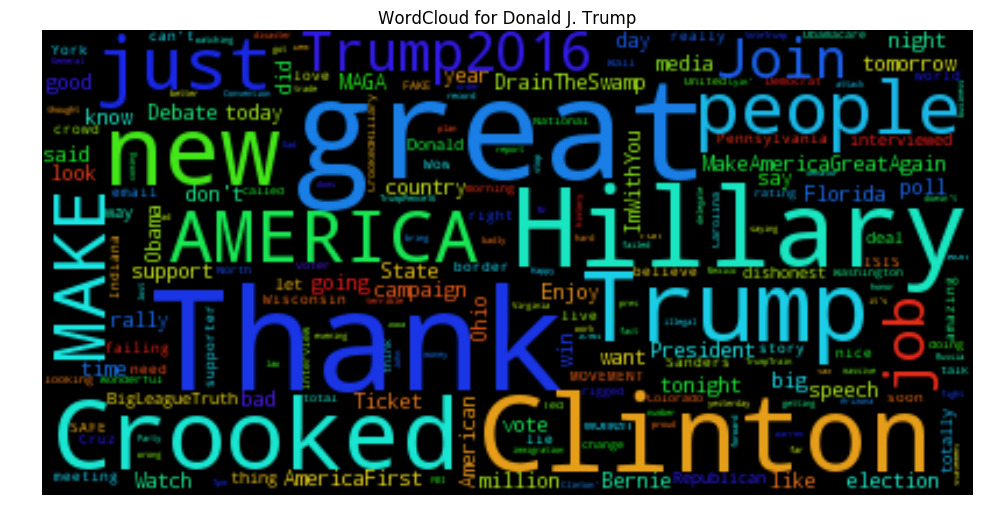

In [11]:
%matplotlib inline

id_list = [df.Id.unique()[0], df.Id.unique()[1]]

@interact
def plot_word_cloud(name= id_list):
    """
    Generates a visual representation of the frequency per word from all the 
    collected tweets by username in the df. 
    
    name : grabs the id_list which is incorporated with the interaction. Based
    on the selection in the drop box it will pass that individual's Id name to 
    the function.
    """
    
    sample_df = df[df['Id'] == name]
    text = ' '.join(sample_df['Tweet'].tolist())
    rt_text = ' '.join([word for word in text.split() if word != 'RT'])
    wordcloud = WordCloud(max_font_size=60, stopwords=stopwords).generate(rt_text)
        
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('WordCloud for {}'.format(name))
    


# NaiveBayes Model

The model will include supervised learning with the user's 'Id' as the response and the 'Tweet' as the predictor variable.

In [13]:
from collections import Counter
from functools import reduce
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.grid_search import GridSearchCV

C:\Users\Shannon\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Shannon\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [14]:
print(Counter(df['Id']))

Counter({'Hillary Clinton': 3200, 'Donald J. Trump': 3200})


In [15]:
X = df['Tweet']
y = df['Id']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .2, random_state=20)

When using text in a model, the data or text needs to be in numeric format. The CountVectorizer function already comes with a list of stopwords, removes punctuation, lowercases the words, and in turn creates a sparse matrix of the data or a document-term matrix. 

Multinomial Naive Bayes is used due to the high dimension of the dataset. Not knowing the most optimal parameters, I start out with using both uni-gram and bi-gram and the english stop word list.

In [17]:
vect = CountVectorizer(ngram_range=(1,2), stop_words=ENGLISH_STOP_WORDS)

X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

nb = MultinomialNB()

nb.fit(X_train_dtm, y_train)
y_pred = nb.predict(X_test_dtm)

print("Accuracy score: ", metrics.accuracy_score(y_pred, y_test))
print(metrics.confusion_matrix(y_pred, y_test))
print(classification_report(y_test, y_pred))

Accuracy score:  0.88828125
[[556  60]
 [ 83 581]]
                 precision    recall  f1-score   support

Donald J. Trump       0.90      0.87      0.89       639
Hillary Clinton       0.88      0.91      0.89       641

    avg / total       0.89      0.89      0.89      1280



As we can see from the above model, we picked the right individuals to try to classify!

The model shows to have a very high accuracy of precticted to actual. However, if we were to take two different users that might not be quite as different in their tweets it would be a good idea to expand the parameters.

# Improving the Model

Even though the results were highly accurate, I am going to remain with Donald Trump and Hillary Clinton for the next example of tuning the parameters. 

Using GridSearchCV from sklearn I use the same test/ train split in order to find the most optimal parameters that minimzes the error in the model, with caution of overfitting.

In [18]:
pipe = make_pipeline(CountVectorizer(stop_words=ENGLISH_STOP_WORDS), MultinomialNB())

#These are the parameters we're searching over
params = {
    'countvectorizer__ngram_range':[(1,1), (1,2), (1,3)],
    'countvectorizer__min_df':[0, 2, 3, 4, 5, 6, 7, 8]
}

grid = GridSearchCV(pipe, params, cv=5)
grid.fit(X_train, y_train)

print("Best CV Score: {:.2f}".format(grid.best_score_))
print("Best parameters: {}".format(grid.best_params_))
print("Score for test sample held out: {}".format(accuracy_score(y_test, grid.predict(X_test))))


Best CV Score: 0.91
Best parameters: {'countvectorizer__ngram_range': (1, 3), 'countvectorizer__min_df': 0}
Score for test sample held out: 0.88828125


The result is similar to the previous, but will identify what the optimal parameters are. Score for the cross validations are lower than for the test sample, which indicates a smaller chance that the model was overfit.

# Examining the Model

Fairly accurate for a collection of text per username. But what if we wanted to see the frequency of the word per user?

Instead of viewing the data in a document-term matrix like below we can use the GridSearchCV object we are able to extract the CountVectorizer and the MultinomialNB classifier. This allows us to create a function that selects the best estimator from the GridSearchCV object. 

The returned ratio dataframe from this function will then be an argument passed to another function that prints out the 10 highest values words for each user. This will provide insight into out model building process and confirm if our data is being tokenized correctly.

In [19]:
sparse_matrix = pd.DataFrame(X_train_dtm.toarray(), columns=vect.get_feature_names())
print(sparse_matrix.head(), 2)

   00  00 alabama  00 automobile  00 discuss  00 eastern  00 enjoy  00 mike  \
0   0           0              0           0           0         0        0   
1   0           0              0           0           0         0        0   
2   0           0              0           0           0         0        0   
3   0           0              0           0           0         0        0   
4   0           0              0           0           0         0        0   

   00 morning  00 movement  00 places   ...    zip  zip code  zucker  \
0           0            0          0   ...      0         0       0   
1           0            0          0   ...      0         0       0   
2           0            0          0   ...      0         0       0   
3           0            0          0   ...      0         0       0   
4           0            0          0   ...      0         0       0   

   zucker failed  él  él dice  él entiende  él tiene  ⁰⁰  ⁰⁰ say  
0              0   0     

In [20]:
# feature_count + 1, so that no division by 0

def get_ratio_df(grid): 
    """Grabs word ration within each user's tweet list, to show most valued words"""
    
    grid_clf = grid.best_estimator_.named_steps['multinomialnb'] 
    count_vect = grid.best_estimator_.named_steps['countvectorizer']
    names = count_vect.get_feature_names()
    
    user1 = (grid_clf.feature_count_[0] + 1)/grid_clf.class_count_[0]
    user2 = (grid_clf.feature_count_[1] + 1)/grid_clf.class_count_[1]
    
    user1_ratio = np.round((user1/user2), 2)
    user2_ratio = np.round((user2/user1), 2)
    
    ratio_df = pd.DataFrame({'Token':names, 'User 1':user1_ratio, 'User 2':user2_ratio})
    
    return ratio_df

In [21]:
def get_most_important(ratio_df, num):
    
    for column in ratio_df.columns[1:]:
        print("Most Frequent words for {}:\n".format(column),'\n', ratio_df.sort_values(by=column,
                                                                                ascending=False)[['Token', column]][:num])
        print('\n')

In [22]:
f = get_ratio_df(grid)
f.head()

,Token,User 1,User 2
0,00,39.97,0.03
1,00 alabama,2.00,0.50
2,00 alabama rally,2.00,0.50
3,00 automobile,2.00,0.50
4,00 automobile executives,2.00,0.50


In [23]:
get_most_important(f, 10)

Most Frequent words for User 1:
 
                          Token  User 1
14020                  crooked  180.86
14040          crooked hillary  155.88
63593                trump2016  133.90
37036    makeamericagreatagain  116.91
3412              americafirst   65.95
18393            draintheswamp   63.95
14053  crooked hillary clinton   59.95
29642                imwithyou   51.96
45577                     poll   51.96
36589                     maga   45.46


Most Frequent words for User 2:
 
                     Token  User 2
16046        demsinphilly   40.03
65067              ve got   33.03
10891             climate   29.02
7609                 born   23.02
24403                gold   22.02
10344                chip   20.02
67111          watch live   20.02
10899      climate change   19.01
57259             student   19.01
51544  rt hillary clinton   19.01




# Conclusion

Although there is a lot more that can be done with this model, this is a good starting demonstration of how text classification  can be used to get fairly accurate results to identify the likely indivdiual of a particular tweet. The notebook covered different visualizations for analysis, document-term matrix, multinominal naive bayes and the use of optimizing parameters through GridSearchCV.
